In [1]:
# IMPORTING LIBRAIRIES
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from configparser import ConfigParser
from astropy.io import fits
from psfao21.psfao21 import psfao21
from psfFitting.psfFitting import psfFitting
import fourier.FourierUtils as FourierUtils
from fourier.fourierModel import fourierModel

mpl.rcParams['font.size'] = 22
usetex = True
plt.rcParams.update({
    "text.usetex": usetex,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})  

In [2]:
#IMPORTING DATA
path_data = '/home/omartin/Projects/WG_ESO/WG_SIMU/DATA/ngs-mode_s0.60as_1265nm_m06/PSF_CL_coo0.0_0.0.fits'
im = fits.getdata(path_data)
hdr = fits.getheader(path_data)
print(hdr)

SIMPLE  =                    T / Written by IDL:  Mon Oct 12 23:22:10 2020      BITPIX  =                  -32 / Number of bits per data pixel                  NAXIS   =                    2 / Number of data axes                            NAXIS1  =                  800 /                                                NAXIS2  =                  800 /                                                DATE    = '2020-04-18'         / Creation UTC (CCCC-MM-DD) date of FITS header  DIR     = '/home/guido/IDLWorkspace/results/ERIS_MAIV/ngs-mode/s0.60as/L0022m/v'TN      = '20191018_150450.0'  /PASSATA Tracking Number                         DIST    = '0.0000000'          /radial distance in arcsec                       ANGLE   = '0.0000000'          /angular coordinate in deg                       PIXSCALE= '6.4283064'          /Pixel scale in mas                              WAVELENG= '1265.0  '           /mean wavelength of the PSF in nm                AOMODE  = 'NGS     '           /AO mode 

In [5]:
#UPDATING PARAMETERS
nPix      = int(hdr['NAXIS1'])
wvl       = 1e-9*float(hdr['WAVELENG']) 
psInMas   = float(hdr['PIXSCALE'])
L0        = float(hdr['L0'])
seeing    = float(hdr['SEEING'])
windspeed = float(hdr['WINDSPEE'])
NGSANGLE  = float(hdr['NGSANGLE'])
NGSDIST   = float(hdr['NGSDIST'])
PSFANGLE  = float(hdr['ANGLE'])
PSFDIST   = float(hdr['DIST'])
NGSFRATE  = float(hdr['NGSFRATE'])
nph_HO    = float(hdr['NGSDETPH'])

if NGSFRATE>667:
    loopDelaySteps_HO = 3
elif NGSFRATE<667 and NGSFRATE>333:
    loopDelaySteps_HO = 2
else:
    loopDelaySteps_HO = 1
    
path_ini = '/home/omartin/Projects/P3/parFiles/eris.ini'
parser = ConfigParser()
parser.optionxform = str
parser.read(path_ini)

parser.set('atmosphere','seeing',str(seeing))
parser.set('atmosphere','L0',str(L0))
parser.set('PSF_DIRECTIONS','psf_FoV',str(nPix))
parser.set('PSF_DIRECTIONS','ScienceWavelength',str([wvl]))
parser.set('PSF_DIRECTIONS','psInMas',str(psInMas))
parser.set('PSF_DIRECTIONS','ScienceZenith',str([PSFDIST]))
parser.set('PSF_DIRECTIONS','ScienceAzimuth',str([PSFANGLE]))
parser.set('GUIDESTARS_HO','GuideStarZenith_HO',str([NGSDIST]))
parser.set('GUIDESTARS_HO','GuideStarAzimuth_HO',str([NGSANGLE]))
parser.set('SENSOR_HO','SensorFrameRate_HO',str(NGSFRATE))
parser.set('SENSOR_HO','loopDelaySteps_HO',str(loopDelaySteps_HO))
parser.set('SENSOR_HO','nph_HO',str(nph_HO))
parser.set('SENSOR_HO','ExcessNoiseFactor_HO',str(2))


if PSFDIST >0: # to test the fit with anisoplanatism; no improvement so far
    nL = 10
    Cn2 = np.array([0.59, 0.02, 0.04, 0.06, 0.01, 0.05, 0.09, 0.04, 0.05, 0.05])
    alt = np.array([30, 140, 281, 562, 1125, 2250, 4500, 7750, 11000, 14000])
    w   = np.array([6.6, 5.9, 5.1, 4.5, 5.1, 8.3, 16.3, 30.2, 34.3, 17.5])
    C2,H2 = FourierUtils.eqLayers(Cn2,alt,nL)
    V2,_ = FourierUtils.eqLayers(w,alt,nL)
    parser.set('atmosphere','Cn2Weights',str(list(C2)))
    parser.set('atmosphere','Cn2Heights',str(list(H2)))
    Vm = V2.mean()
    w = np.round(V2 * windspeed/Vm,2)
    parser.set('atmosphere','wSpeed',str(list(w)))
    parser.set('atmosphere','wDir',str(list(np.zeros(len(w)))))
else:
    parser.set('atmosphere','Cn2Weights',str([1.]))
    parser.set('atmosphere','Cn2Heights',str([0.]))
    parser.set('atmosphere','wSpeed',str([windspeed]))
    parser.set('atmosphere','wDir',str([10]))
with open(path_ini, 'w') as configfile:
            parser.write(configfile)

F    = im.max()

Text(0, 0.5, 'Azimuthal profile')

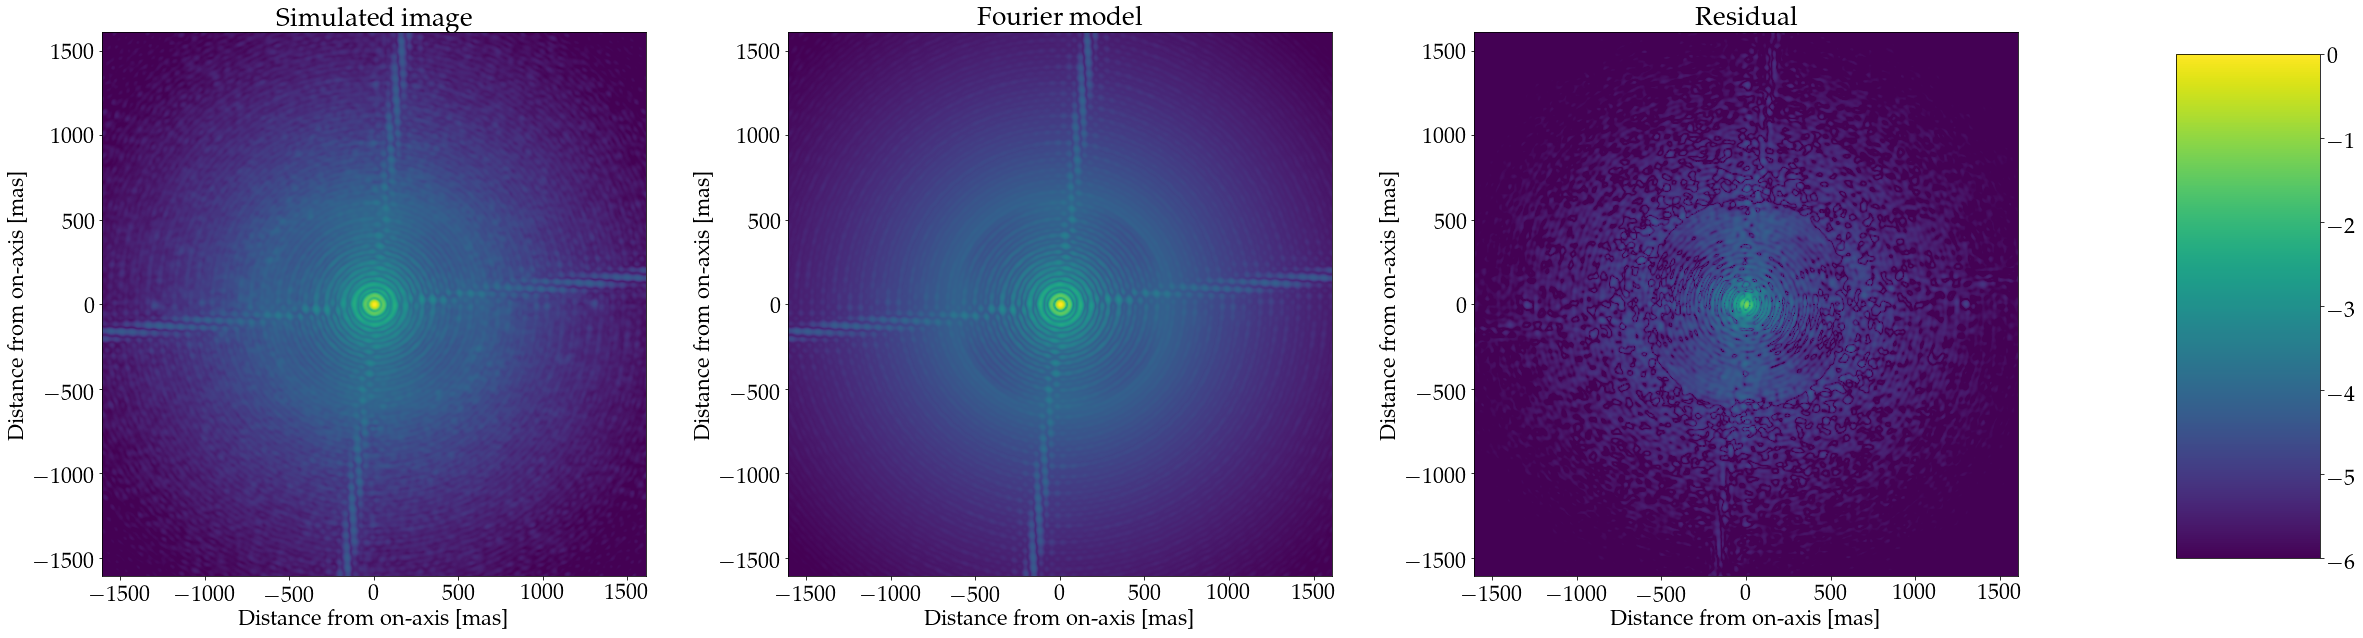

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


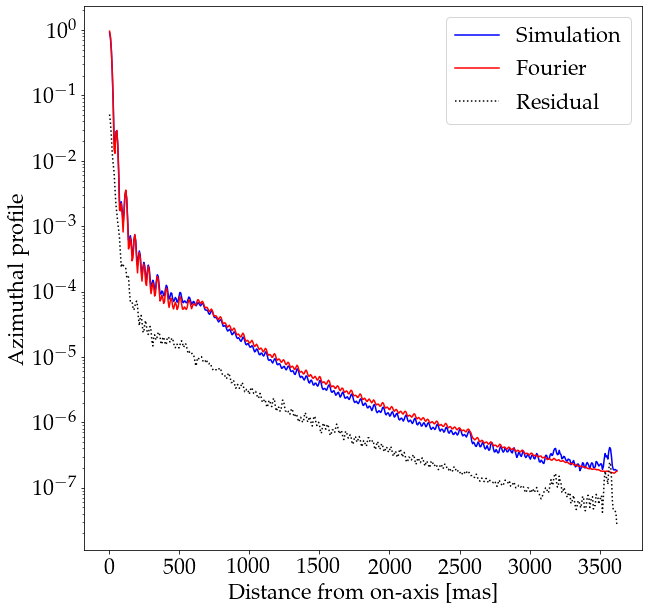

In [6]:
# COMPUTING THE FOURIER PSF
fao = fourierModel(path_ini,display=False)
psf_fourier = fao.PSF[:,:,0,0]

nBox = 500
nC   = nPix/nBox
fov  = nBox*psInMas
vmin = -6

plt.close('all')
fig, axs = plt.subplots(1,3,figsize=(40,10))
axs[0].imshow(np.log10(FourierUtils.cropSupport(im,nC)/F),vmin=vmin,vmax=0,extent=[-fov/2,fov/2,-fov/2,fov/2])
axs[0].set_xlabel('Distance from on-axis [mas]')
axs[0].set_ylabel('Distance from on-axis [mas]')
axs[0].set_title('Simulated image')

axs[1].imshow(np.log10(FourierUtils.cropSupport(psf_fourier,nC)/F),vmin=vmin,vmax=0,extent=[-fov/2,fov/2,-fov/2,fov/2])
axs[1].set_xlabel('Distance from on-axis [mas]')
axs[1].set_ylabel('Distance from on-axis [mas]')
axs[1].set_title('Fourier model')

pcm=axs[2].imshow(np.log10(FourierUtils.cropSupport(abs(psf_fourier/F - im/F),nC)),vmin=vmin,vmax=0,extent=[-fov/2,fov/2,-fov/2,fov/2])
axs[2].set_xlabel('Distance from on-axis [mas]')
axs[2].set_ylabel('Distance from on-axis [mas]')
axs[2].set_title('Residual')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(pcm, cax=cbar_ax)

x , prof_sky = FourierUtils.radial_profile(im/F)
x = x*psInMas
plt.figure(figsize=(10,10))
plt.semilogy(x,prof_sky,'b',label='Simulation')
plt.semilogy(x,FourierUtils.radial_profile(psf_fourier/F,nargout=1),'r',label='Fourier')
plt.semilogy(x,FourierUtils.radial_profile(abs(im/F - psf_fourier/F),nargout=1),'k:',label='Residual')
plt.legend()
plt.xlabel('Distance from on-axis [mas]')
plt.ylabel('Azimuthal profile')

In [6]:
# INSTANTIATING THE PSF MODEL
psfao = psfao21(path_ini)

[3.5351307778666907, 0.004, 0.3808513326869396, 0.01, 1, 0, 1.7, 0, 0, 0]
(False, False, False, False, False, False, False, True, True, True)


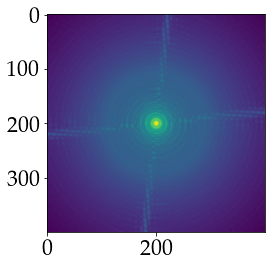

In [9]:
airmass = 1/np.cos(psfao.tel.zenith_angle*np.pi/180)
Cn2= airmass * psfao.atm.r0**(-5/3) * (psfao.atm.wvl/wvl)**2 * psfao.atm.weights
wfe = np.sqrt(-np.log(float(hdr['SR'])))
x0 = list(Cn2) + [4e-3,wfe,1e-2,1,0,1.7,0,0,0,1,0.5,0.5,0]
fixed = (False,)*psfao.atm.nL + (False,False,False,False,False,False,True,True,True,True,True,True)
psf = psfao(x0)
plt.imshow(np.log10(FourierUtils.cropSupport(psf,2)))
print(x0)
print(fixed)

In [11]:
# MODEL FITTING TO DATA
import time
t0 = time.time()
res = psfFitting(im,psfao,x0,fixed=fixed,method='trf',verbose=2)
print(time.time()-t0)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.9906e-05                                    6.40e-04    
       1              2         9.0730e-06      7.08e-05       6.34e-01       1.04e-04    
       2              3         2.3707e-06      6.70e-06       6.17e-01       1.74e-05    
       3              4         1.2169e-06      1.15e-06       2.29e-01       2.69e-06    
       4              5         1.1145e-06      1.02e-07       9.59e-02       1.19e-06    
       5              6         1.0974e-06      1.71e-08       1.05e-01       3.13e-07    
       6              7         1.0909e-06      6.48e-09       2.09e-01       5.47e-07    
       7              8         1.0889e-06      1.95e-09       8.99e-02       1.25e-07    
       8              9         1.0881e-06      8.12e-10       1.63e-01       2.53e-07    
       9             10         1.0879e-06      2.20e-10       4.31e-02       2.75e-08    

Text(0, 0.5, 'Azimuthal profile')

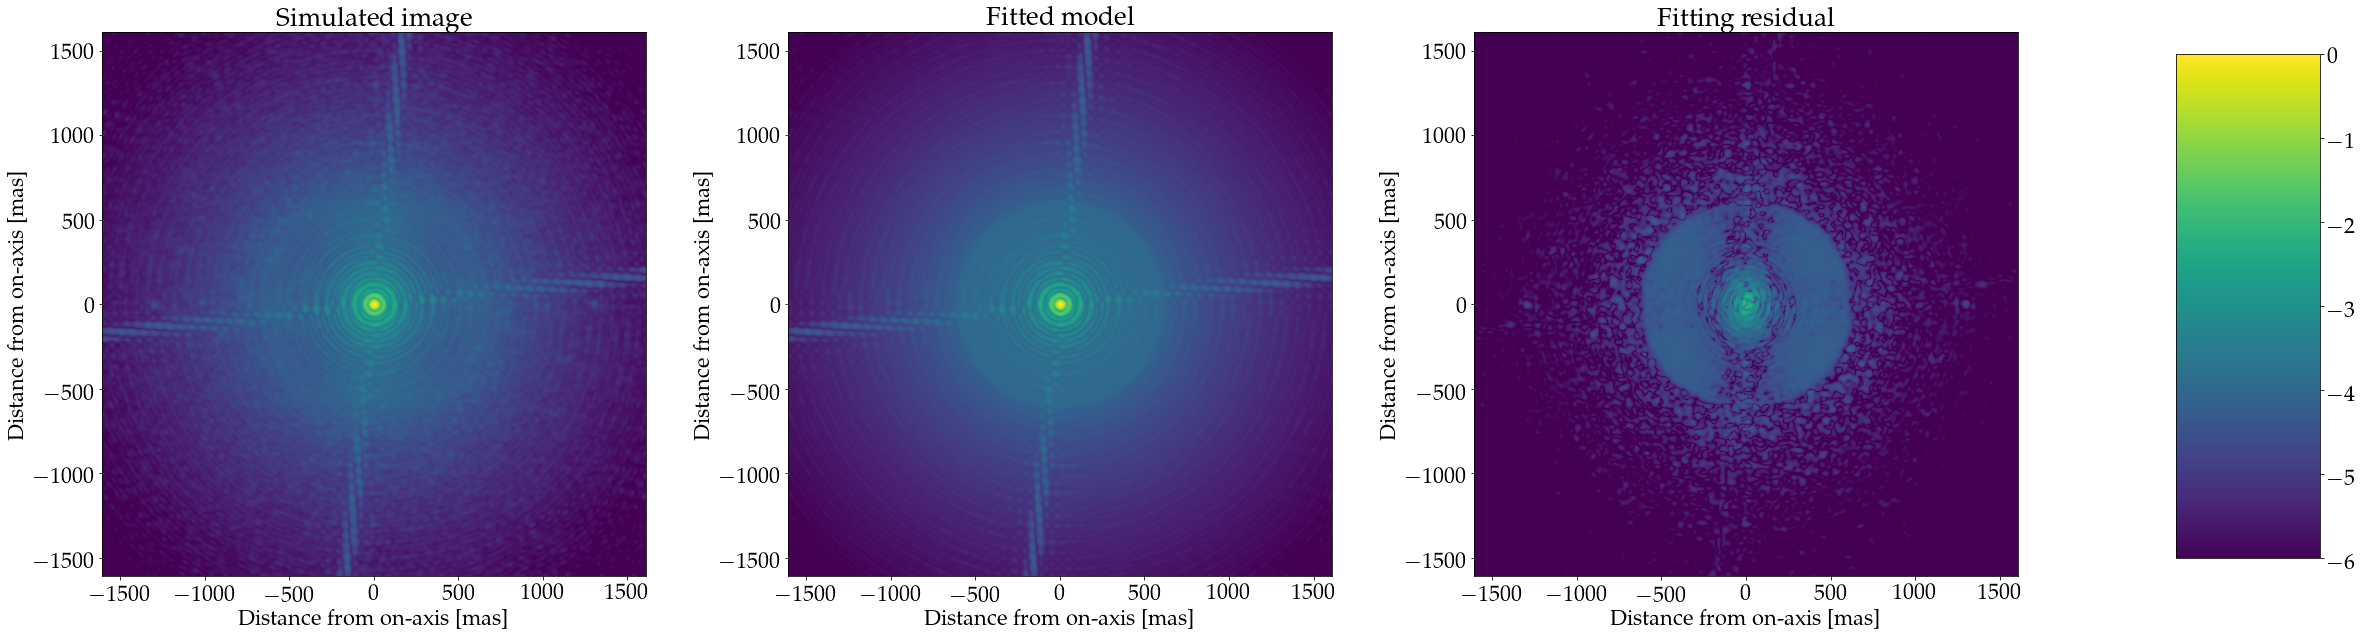

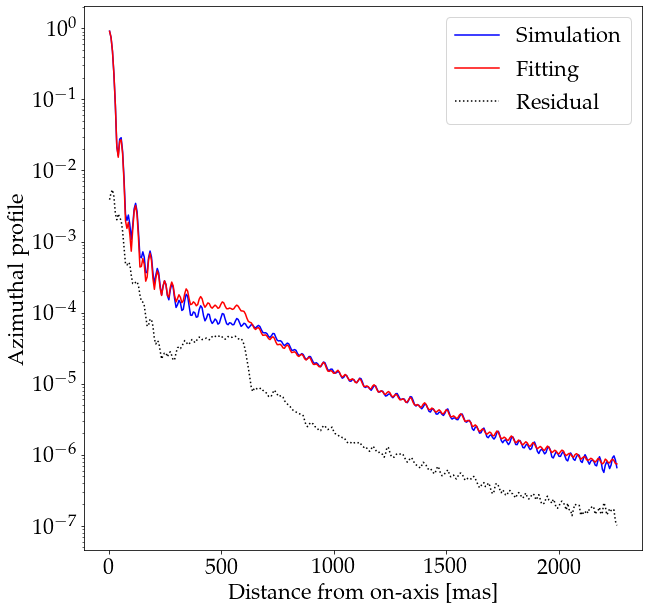

In [10]:
nBox = 500
nC   = nPix/nBox
fov  = nBox*psInMas
vmin = -6

plt.close('all')
fig, axs = plt.subplots(1,3,figsize=(40,10))
axs[0].imshow(np.log10(FourierUtils.cropSupport(res.im_sky,nC)/F),vmin=vmin,vmax=0,extent=[-fov/2,fov/2,-fov/2,fov/2])
axs[0].set_xlabel('Distance from on-axis [mas]')
axs[0].set_ylabel('Distance from on-axis [mas]')
axs[0].set_title('Simulated image')

axs[1].imshow(np.log10(FourierUtils.cropSupport(res.im_fit,nC)/F),vmin=vmin,vmax=0,extent=[-fov/2,fov/2,-fov/2,fov/2])
axs[1].set_xlabel('Distance from on-axis [mas]')
axs[1].set_ylabel('Distance from on-axis [mas]')
axs[1].set_title('Fitted model')

pcm=axs[2].imshow(np.log10(FourierUtils.cropSupport(abs(res.im_fit/F - res.im_sky/F),nC)),vmin=vmin,vmax=0,extent=[-fov/2,fov/2,-fov/2,fov/2])
axs[2].set_xlabel('Distance from on-axis [mas]')
axs[2].set_ylabel('Distance from on-axis [mas]')
axs[2].set_title('Fitting residual')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(pcm, cax=cbar_ax)

x , prof_sky = FourierUtils.radial_profile(FourierUtils.cropSupport(res.im_sky/F,nC))
x = x*psInMas
plt.figure(figsize=(10,10))
plt.semilogy(x,prof_sky,'b',label='Simulation')
plt.semilogy(x,FourierUtils.radial_profile(FourierUtils.cropSupport(res.im_fit/F,nC),nargout=1),'r',label='Fitting')
plt.semilogy(x,FourierUtils.radial_profile(FourierUtils.cropSupport(abs(res.im_fit/F - res.im_sky/F),nC),nargout=1),'k:',label='Residual')
plt.legend()
plt.xlabel('Distance from on-axis [mas]')
plt.ylabel('Azimuthal profile')

In [11]:
print('Header SR\t:',np.round(float(hdr['SR']),2))
print('Image SR\t:',res.SR_sky)
print('Fitted SR\t:',res.SR_fit)
print('Header FWHM\t:',np.round(float(hdr['FWHM']),2))
print('Image FWHM\t:',np.round(0.5*(res.FWHMy_sky+res.FWHMx_sky),2))
print('Fit FWHM\t:',np.round(0.5*(res.FWHMy_fit+res.FWHMx_fit),2))

Header SR	: 0.86
Image SR	: 0.81
Fitted SR	: 0.81
Header FWHM	: 31.83
Image FWHM	: 32.81
Fit FWHM	: 32.84


In [12]:
print(res.x)
print(res.xinit)

[2.76231637e+00 4.85431302e-03 2.79785291e-01 3.33602656e-07
 7.37741696e-01 3.41500156e-01 2.60111395e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[3.5351307778666907, 0.004, 0.3808513326869396, 0.01, 1, 0, 1.7, 0, 0, 0]


In [14]:
print((res.x[0:psfao.atm.nL].sum())**(-3/5))
print((206264.8 * 0.976*500e-9/seeing) * (wvl/500e-9)**1.2 * airmass**(-3/5))

0.5435455566800681
0.46876663863291385
